In [1]:
import numpy as np
import keras
import pandas as pd 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM,Bidirectional
import re
import tensorflow as tf
from keras.preprocessing.text import Tokenizer

In [2]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool1D, Concatenate, Flatten, Dropout, Dense, Conv1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam,SGD
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/3-classes-bangla-sa/3_classes_Bert_Preprocessed__Dataset.xlsx


In [4]:
pip install openpyxl

     |████████████████████████████████| 242 kB 912 kB/s            
Note: you may need to restart the kernel to use updated packages.


In [5]:
df=pd.read_excel('/kaggle/input/3-classes-bangla-sa/3_classes_Bert_Preprocessed__Dataset.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15728 entries, 0 to 15727
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  15728 non-null  int64 
 1   Data        15728 non-null  object
 2   Label       15728 non-null  int64 
 3   Token       15728 non-null  object
 4   Token_ID    15728 non-null  object
dtypes: int64(2), object(3)
memory usage: 614.5+ KB


In [6]:
df.head()

,Unnamed: 0,Data,Label,Token,Token_ID
0,4032,এক মাস সেহেরি খাইয়া রোজা রাহা সোজা,1,"['এক', 'মাস', 'সে', '##হের', '##ি', '[UNK]', '...","[788, 1293, 809, 2685, 416, 1, 12209, 3462, 41..."
1,3587,ভাই আমাদের মাতৃভুমিটা এত সুনদর,1,"['ভাই', 'আমাদের', 'মাতৃ', '##ভু', '##মিট', '##...","[1352, 1029, 6563, 12357, 12290, 415, 1284, 36..."
2,8968,জানুয়ারীতে কেন ঐ সময় স্পেশাল কি,1,"['[UNK]', 'কেন', 'ঐ', '[UNK]', 'স্পেশাল', 'কি']","[1, 1107, 218, 1, 10225, 817]"
3,95,তোরা কখন কাচা রসুন চাবিয়ে খেয়ে দেখেচিস,2,"['তোরা', 'কখন', 'কাচা', 'রসুন', '[UNK]', '[UNK...","[5712, 1394, 30306, 18173, 1, 1, 1172, 2408, 417]"
4,1163,হ্যাঁ হ্যাঁ হ্যাঁ হ্যাঁ জীবন টা বেদনা,2,"['হ্যাঁ', 'হ্যাঁ', 'হ্যাঁ', 'হ্যাঁ', 'জীবন', '...","[2154, 2154, 2154, 2154, 1537, 1632, 10018]"


<AxesSubplot:xlabel='Label', ylabel='count'>

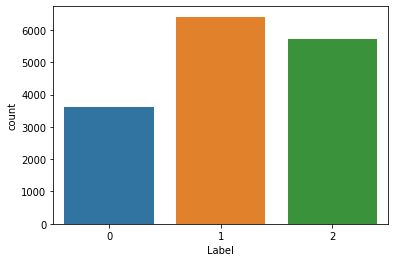

In [7]:
sns.countplot(df['Label'])

In [8]:
df.Label.value_counts(), len(df)

(1    6410
 2    5709
 0    3609
 Name: Label, dtype: int64,
 15728)

In [9]:
df_filtered = df[df['Label'] > 0]

In [10]:
df=df_filtered

<AxesSubplot:xlabel='Label', ylabel='count'>

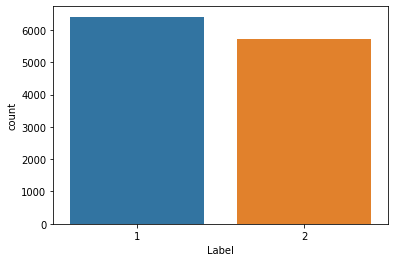

In [11]:
sns.countplot(df['Label'])

In [12]:
maxlen = 200
max_features = 10000
batch_size = 32

In [13]:
df['Token']=df['Token'].astype('str')

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['Token'],df['Label'] , test_size=0.1,random_state=2)
x_train, x_validation, y_train, y_validation = train_test_split(x_train,y_train,test_size=0.1,random_state=42)

In [15]:
vocab_size=32000

In [16]:
tokenizer  = Tokenizer(num_words = max_features,oov_token = "<OOV>")
tokenizer.fit_on_texts(df['Token'])

train_seq =  tokenizer.texts_to_sequences(x_train)
val_seq =  tokenizer.texts_to_sequences(x_validation)
test_seq = tokenizer.texts_to_sequences(x_test)

In [17]:
x_train = pad_sequences(train_seq, maxlen=maxlen, dtype='int32', padding='post',truncating='post') #maxlen = maxlen, padding='post')
x_validation = pad_sequences(val_seq, maxlen=maxlen, dtype='int32', padding='post',truncating='post') #maxlen = maxlen, padding='post')
x_test = pad_sequences(test_seq, maxlen=maxlen, dtype='int32', padding='post',truncating='post') #maxlen = maxlen, padding='post')

In [18]:
model= Sequential()
model.add(Embedding(vocab_size,40,input_length=maxlen,name='Embedding'))
model.add(Conv1D(200, kernel_size=3, activation = "relu"))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.1))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(25, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(12, activation='relu'))
model.add(Flatten())
model.add(Dense(units=3, activation='softmax'))
adam=Adam(learning_rate=0.003)
model.summary()
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

2022-11-09 05:16:55.784395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 05:16:55.898763: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 05:16:55.899580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 05:16:55.901091: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 200, 40)           1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 198, 200)          24200     
_________________________________________________________________
bidirectional (Bidirectional (None, 198, 256)          336896    
_________________________________________________________________
dropout (Dropout)            (None, 198, 256)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                6

In [19]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=15,
    min_delta=0.001,
    restore_best_weights=True,
)

In [20]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=30, callbacks=[early_stopping],verbose=1, validation_data=(x_validation, y_validation))

2022-11-09 05:16:59.806755: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-11-09 05:17:05.306433: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


307/307 [==============================] - 26s 46ms/step - loss: 0.6316 - accuracy: 0.6475 - val_loss: 0.4359 - val_accuracy: 0.8213
Epoch 2/30
307/307 [==============================] - 13s 41ms/step - loss: 0.3518 - accuracy: 0.8612 - val_loss: 0.3650 - val_accuracy: 0.8396
Epoch 3/30
307/307 [==============================] - 13s 41ms/step - loss: 0.2189 - accuracy: 0.9216 - val_loss: 0.4044 - val_accuracy: 0.8387
Epoch 4/30
307/307 [==============================] - 12s 41ms/step - loss: 0.1353 - accuracy: 0.9577 - val_loss: 0.4237 - val_accuracy: 0.8497
Epoch 5/30
307/307 [==============================] - 13s 41ms/step - loss: 0.0896 - accuracy: 0.9739 - val_loss: 0.5201 - val_accuracy: 0.8570
Epoch 6/30
307/307 [==============================] - 13s 41ms/step - loss: 0.0634 - accuracy: 0.9839 - val_loss: 0.6027 - val_accuracy: 0.8506
Epoch 7/30
307/307 [==============================] - 12s 41ms/step - loss: 0.0510 - accuracy: 0.9869 - val_loss: 0.5920 - val_accuracy: 0.8506
Epo

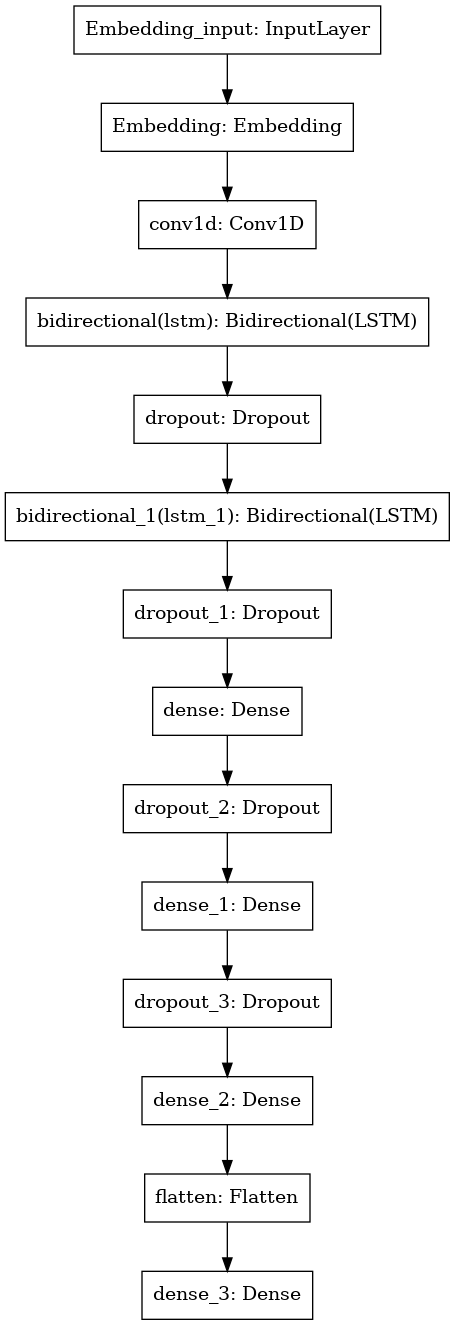

In [21]:
tf.keras.utils.plot_model(model, to_file='2 classes Conv-BiLSTM model.png', show_shapes=False,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [22]:
model.evaluate(x_test, y_test)

38/38 [==============================] - 1s 18ms/step - loss: 0.3886 - accuracy: 0.8267


[0.38864925503730774, 0.8267326951026917]

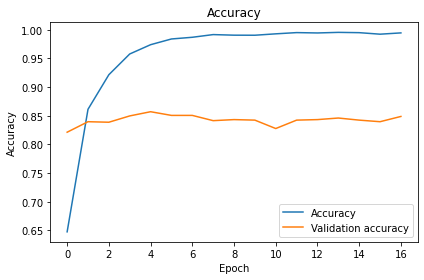

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label="Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('2 classes Conv-BiLSTM Val_acc.png',format='png',transparent='True')
plt.show()

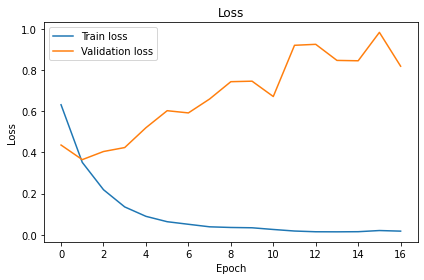

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label="Train loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('2 classes Conv-BiLSTM Val_loss.png',format='png',transparent='True')
plt.show()

In [25]:
from sklearn.metrics import classification_report

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)

In [26]:
print(y_test.shape)
print(y_pred.shape)

(1212,)
(1212,)


In [27]:
y_pred = y_pred.reshape(-1,1)


In [28]:
categories = ['positive','negative']
print(classification_report(y_test, y_pred, target_names=categories))

              precision    recall  f1-score   support

    positive       0.79      0.89      0.84       607
    negative       0.87      0.76      0.81       605

    accuracy                           0.83      1212
   macro avg       0.83      0.83      0.83      1212
weighted avg       0.83      0.83      0.83      1212



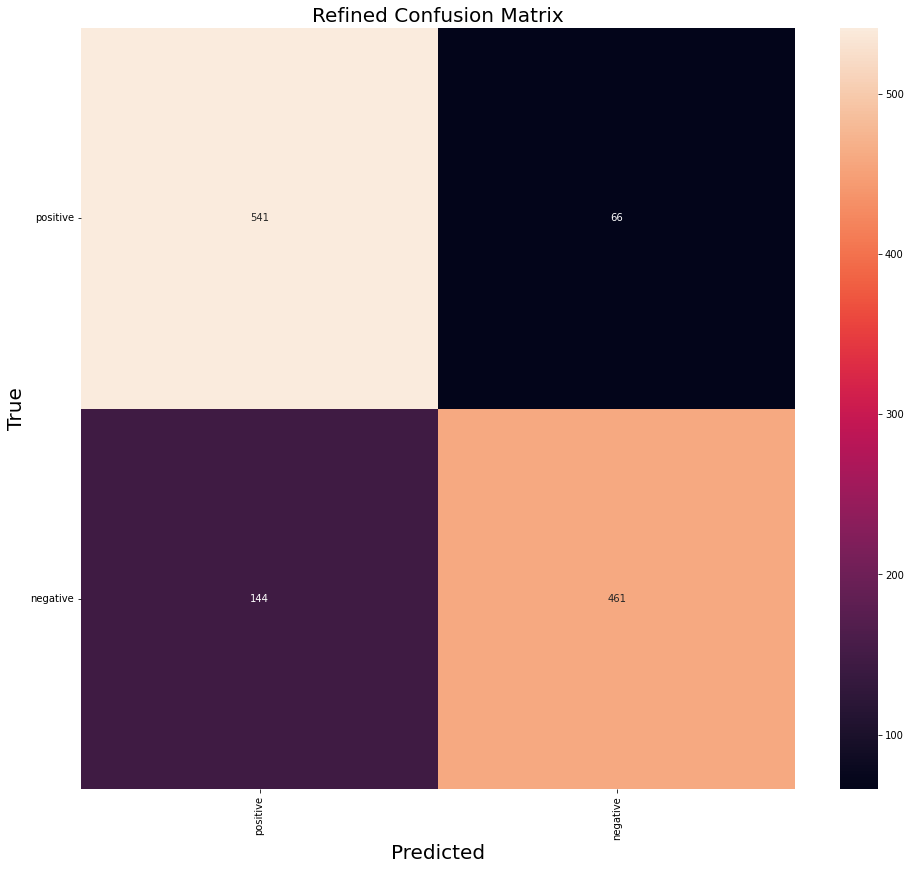

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
#predictions = model.predict(x_test, steps=len(x_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)


cm = confusion_matrix(y_test, y_pred)

## Get Class Labels
labels = 2
#[0,1,2,3,4,5]_
class_names = categories 

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.savefig('2 classes Conv-BiLSTM Confusion Matrix.png')
plt.show()